# Libraries

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from transformers import GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification, BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset as TorchDataset
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter

# Preprocessing

In [3]:
# count: number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when 
# hate_speech: number of CF users who judged the tweet to be hate speech
# offensive_language: number of CF users who judged the tweet to be offensive
# neither: number of CF users who judged the tweet to be neither offensive nor non-offensive
# class: class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
# tweet: text tweet

writer = SummaryWriter(log_dir="./logs")

def parse_tweets_until_colon(data):
    parsed_tweets = []
    for tweet in data['tweet']:
        colon_index = tweet.find(':')
        if colon_index != -1:
            parsed_tweets.append(tweet[colon_index + 1:])
        else:
            parsed_tweets.append(tweet)
    return parsed_tweets

data = pd.read_csv('labeled_data.csv')
data = data.drop(columns='Unnamed: 0')
data['tweet'] = parse_tweets_until_colon(data)

data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about clean...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat h...
2,3,0,3,0,1,You ever fuck a bitch and she start to cry? Y...
3,3,0,2,1,1,@viva_based she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or i...


# Text cleaning

In [4]:
# Text Cleaning:
# Lowercasing: Convert all text to lowercase to ensure uniformity.
# Removing Punctuation: Eliminate punctuation marks as they often don't carry much meaning in NLP tasks.
# Removing Special Characters: Remove special characters, emojis, URLs, etc., which may not contribute to the task at hand.
# Removing Stopwords: Stopwords are common words (e.g., "the", "is", "and") that occur frequently but often carry little information. Removing them can reduce noise in the data.

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

def clean_text(data):
    cleaned_tweets = []
    for tweet in data["tweet"]:
        tweet = tweet.lower()  # Convert text to lowercase
        tweet = re.sub(r"[^\w\s]", "", tweet)  # Remove punctuation
        tweet = re.sub(r"\d+", "", tweet)  # Remove numbers
        tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra whitespaces
        cleaned_tweets.append(tweet)
    return cleaned_tweets

def remove_stopwords(data):
    nostopwords_tweets = []
    for tweet in data["tweet"]:
        tokens = word_tokenize(tweet)  # Tokenize text
        stop_words = set(stopwords.words("english"))
        filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        filtered_text = " ".join(filtered_tokens)  # Join tokens back into a string
        nostopwords_tweets.append(filtered_text)
    return nostopwords_tweets

def apply_stemming(data):
    stemmer = PorterStemmer()
    stemmed_tweets = []
    for tweet in data["tweet"]:
        tokens = word_tokenize(tweet)  # Tokenize text
        stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Apply stemming
        stemmed_text = " ".join(stemmed_tokens)  # Join tokens back into a string
        stemmed_tweets.append(stemmed_text)
    return stemmed_tweets

def apply_lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweets = []
    for tweet in data["tweet"]:
        tokens = word_tokenize(tweet)  # Tokenize text
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Apply lemmatization
        lemmatized_text = " ".join(lemmatized_tokens)  # Join tokens back into a string
        lemmatized_tweets.append(lemmatized_text)
    return lemmatized_tweets

data["tweet"] = clean_text(data)
data["tweet"] = remove_stopwords(data)
data["tweet"] = apply_stemming(data)
data["tweet"] = apply_lemmatization(data)

data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eddy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eddy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eddy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,woman shouldnt complain clean hous amp man alw...
1,3,0,3,0,1,boy dat coldtyga dwn bad cuffin dat hoe st place
2,3,0,3,0,1,ever fuck bitch start cri confus shit
3,3,0,2,1,1,viva_bas look like tranni
4,6,0,6,0,1,shit hear might true might faker bitch told ya


## Split training/test set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["class"], test_size=0.2, random_state=1)

# GPT-2

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token  # Set padding token to eos_token

max_length = 128
tokenized_texts_train = tokenizer_gpt2(list(X_train), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
tokenized_texts_test = tokenizer_gpt2(list(X_test), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

labels_train = torch.tensor(list(y_train)).to(device)
labels_test = torch.tensor(list(y_test)).to(device)

train_dataset_gpt2 = TensorDataset(tokenized_texts_train.input_ids, tokenized_texts_train.attention_mask, labels_train)
test_dataset_gpt2 = TensorDataset(tokenized_texts_test.input_ids, tokenized_texts_test.attention_mask, labels_test)

batch_size = 128

train_loader = DataLoader(train_dataset_gpt2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_gpt2, batch_size=batch_size, shuffle=False)

model_config_gpt2 = GPT2Config.from_pretrained('gpt2', num_labels=3, pad_token_id=tokenizer_gpt2.pad_token_id)
model_gpt2 = GPT2ForSequenceClassification(model_config_gpt2).to(device)

optimize_gpt2 = AdamW(model_gpt2.parameters(), lr=5e-5, no_deprecation_warning=True)

epochs = 5

for epoch in range(epochs):
    model_gpt2.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimize_gpt2.zero_grad()
        outputs = model_gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        writer.add_scalar("Loss/train_gpt2", loss, epoch)
        total_loss += loss.item()
        loss.backward()
        optimize_gpt2.step()
    print(f'Epoch {epoch + 1}: Average Loss: {total_loss / len(train_loader)}')

writer.flush()

model_gpt2.eval()
predicted_labels_gpt2 = []
true_labels_gpt2 = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model_gpt2(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels_gpt2.extend(torch.argmax(logits, axis=1).tolist())
        true_labels_gpt2.extend(labels.tolist())

accuracy_gpt2 = accuracy_score(true_labels_gpt2, predicted_labels_gpt2)
print(f'GPT-2 Accuracy: {accuracy_gpt2}')

Using cuda for training
Epoch 1: Average Loss: 0.5102600366838517
Epoch 2: Average Loss: 0.30821760258366987
Epoch 3: Average Loss: 0.24060534479156617
Epoch 4: Average Loss: 0.18884599708741712
Epoch 5: Average Loss: 0.1501495545429568
GPT-2 Accuracy: 0.8656445430704055


# BERT

In [7]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts_train_bert = tokenizer_bert(list(X_train), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
tokenized_texts_test_bert = tokenizer_bert(list(X_test), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

train_dataset_bert = TensorDataset(tokenized_texts_train_bert.input_ids, tokenized_texts_train_bert.attention_mask, labels_train)
test_dataset_bert = TensorDataset(tokenized_texts_test_bert.input_ids, tokenized_texts_test_bert.attention_mask, labels_test)

train_loader_bert = DataLoader(train_dataset_gpt2, batch_size=batch_size, shuffle=True)
test_loader_bert = DataLoader(test_dataset_gpt2, batch_size=batch_size, shuffle=False)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=batch_size, shuffle=True)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=batch_size, shuffle=False)

model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)

optimizer_bert = AdamW(model_bert.parameters(), lr=5e-5, no_deprecation_warning=True)

print("Training BERT model...")
for epoch in range(epochs):
    model_bert.train()
    total_loss = 0
    for batch in train_loader_bert:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer_bert.zero_grad()
        
        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        writer.add_scalar("Loss/train_bert", loss, epoch)
        total_loss += loss.item()
        
        loss.backward()
        optimizer_bert.step()
    
    avg_loss = total_loss / len(train_loader_bert)
    print(f'Epoch {epoch + 1}: Average Loss: {avg_loss}')

writer.flush()
writer.close()
# Evaluation for BERT
model_bert.eval()
predicted_labels_bert = []
true_labels_bert = []

with torch.no_grad():
    for batch in test_loader_bert:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels_bert.extend(torch.argmax(logits, axis=1).tolist())
        true_labels_bert.extend(labels.tolist())

accuracy_bert = accuracy_score(true_labels_bert, predicted_labels_bert)
print(f'BERT Accuracy: {accuracy_bert}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model...
Epoch 1: Average Loss: 0.36312111058542806
Epoch 2: Average Loss: 0.2654220319563343
Epoch 3: Average Loss: 0.22395093340066172
Epoch 4: Average Loss: 0.17507132613851178
Epoch 5: Average Loss: 0.12985741300207954
BERT Accuracy: 0.8815816017752673


# Testing on some sentences

In [34]:
input_sentences = ["weather is wonderful today", "fucking bitch you are so stupid", "go back to africa nigga", "stupid autistic nigga"]

messages = ["hate speech", "offensive language", "message approved"]

for input_sentence in input_sentences:
    print(f"Input: {input_sentence}")

    # Tokenize input for BERT
    input_ids_bert = tokenizer_bert.encode(input_sentence, return_tensors='pt').to(device)
    attention_mask_bert = torch.ones_like(input_ids_bert).to(device)

    # Generate output for BERT
    with torch.no_grad():
        outputs_bert = model_bert(input_ids_bert, attention_mask=attention_mask_bert)
        predicted_class_bert = torch.argmax(outputs_bert.logits, dim=1).item()

    print(f"BERT Response: Class {predicted_class_bert} - {messages[predicted_class_bert]}")

    # Tokenize input for GPT-2
    input_ids_gpt2 = tokenizer_gpt2.encode(input_sentence, return_tensors='pt').to(device)
    attention_mask_gpt2 = torch.ones_like(input_ids_gpt2).to(device)

    # Generate output for GPT-2
    with torch.no_grad():
        outputs_gpt2 = model_gpt2(input_ids_gpt2, attention_mask=attention_mask_gpt2)
        predicted_class_gpt2 = torch.argmax(outputs_gpt2.logits, dim=1).item()

    print(f"GPT-2 Response: Class {predicted_class_gpt2} - {messages[predicted_class_gpt2]}\n")

Input: weather is wonderful today
BERT Response: Class 2 - message approved
GPT-2 Response: Class 2 - message approved

Input: fucking bitch you are so stupid
BERT Response: Class 1 - offensive language
GPT-2 Response: Class 1 - offensive language

Input: go back to africa nigga
BERT Response: Class 1 - offensive language
GPT-2 Response: Class 0 - hate speech

Input: stupid autistic nigga
BERT Response: Class 0 - hate speech
GPT-2 Response: Class 0 - hate speech



# Plot

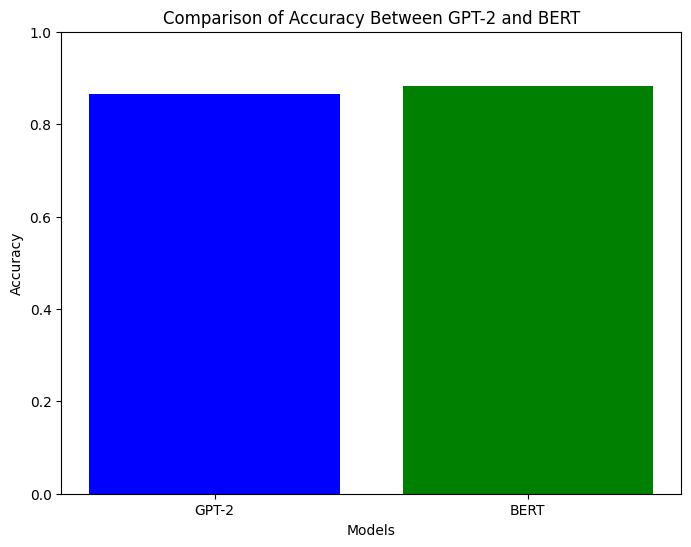

In [21]:
models = ['GPT-2', 'BERT']
accuracies = [accuracy_gpt2, accuracy_bert]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Between GPT-2 and BERT')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.show()